In [3]:
from TriggerStudyBinaries_v6 import *

example_signal = np.loadtxt("/cr/tempdata01/filip/iRODS/SignalError/jaco_randoms0026.csv")
FPGA_baseline, example_signal = example_signal[0][0], example_signal[0][1:]

2022-08-21 11:11:04.607114: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-21 11:11:04.607133: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


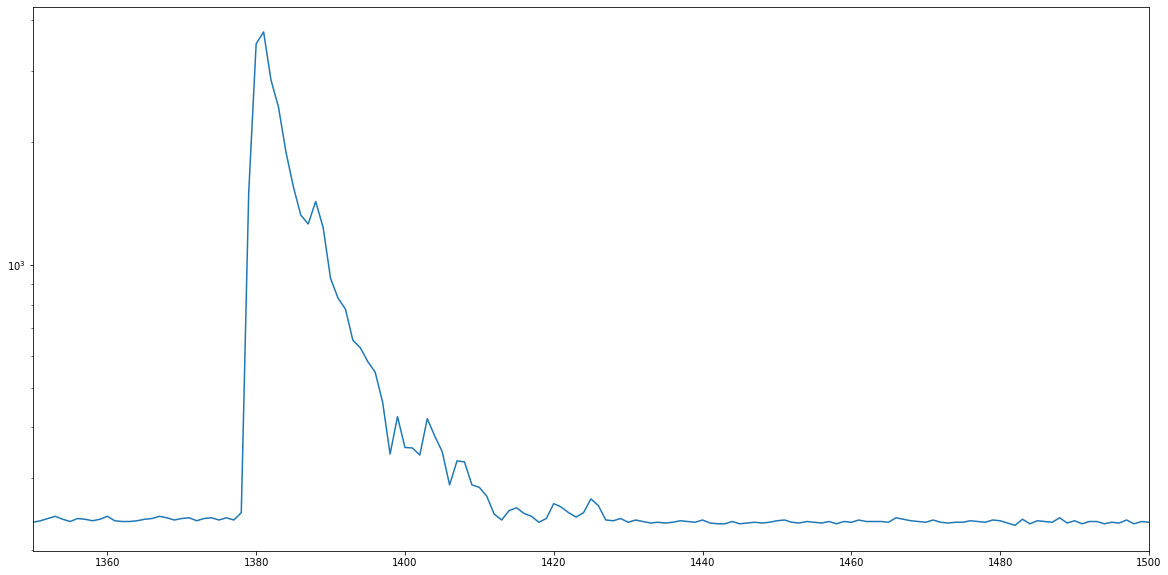

In [58]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.plot(range(len(example_signal) - 1), example_signal[1:] + FPGA_baseline)
# plt.axhline(example_signal[0], ls = "--", c = "k", lw = 2)
# plt.axhline(np.mean(example_signal[1:] + example_signal[0]), ls = "--", c = "orange", lw = 2)
plt.xlim(1350, 1500)
plt.yscale("log")

In [48]:
class ElectronicsError(Exception) : pass
class SignalError(Exception) : pass

# Implementation of Tobias Schulz baseline algorithm in python
def corrected_baseline(trace : np.ndarray) -> np.ndarray :

    def calculate_baseline(*args) -> list :

        baselines = []
        for window in args:

            while True:

                mode, count = None, 0
                
                # calculate mode of the trace windows
                for value in range(int(min(window)), int(max(window))):
                    current_count = window.count(value)
                    if current_count > count:
                        mode, count = value, current_count

                upper, lower = mode + 2* np.std(window), mode - 2* np.std(window)
                to_remove = [bin for bin in window if bin > upper or bin < lower]           
                if to_remove != []: [window.remove(value) for value in to_remove]
                else: break

            baselines.append([np.mean(window), np.std(window)])

        return baselines

    (i, sigma_i), (f, sigma_f) = calculate_baseline(list(trace[:300]), list(trace[-300:]))
    delta_B, sigma_B = f - i, np.sqrt(sigma_i**2 + sigma_f**2)

    if delta_B >= 5 * sigma_B: raise ElectronicsError                               # discard trace
    
    elif 5 * sigma_B > delta_B >= 0:                                                # approx. constant
        
        Baseline, _ =  calculate_baseline(list(trace))[0]
        return trace - Baseline

    elif 0 > delta_B >= -sigma_B or (-sigma_B > delta_B and (max(trace) - i) < 50): # step function

        front, end = trace[:np.argmax(trace)], trace[np.argmax(trace):]
        return np.array(list(front - i) + list(end - f))
    
    elif -sigma_B > delta_B:                                                        # signal undershoot
        
        interpolated_baseline = [i + delta_B * (bin - 300)/1448 for bin in range(300, 1748)]
        interpolated_baseline += [f for i in range(300)]
        interpolated_baseline = np.array(interpolated_baseline)
        
        q_front = np.sum(trace[:300] - i)                                           # front estimate integral
        tau     = 41e-6 / 8.33e-9                                                   # decay constant ~4922 bins
        bins    = np.array(range(1748))                                             # bin difference from start

        for iteration in range(4):
            
            intermediate_trace = trace[300:] - interpolated_baseline
            q_ref = q_front + np.sum(intermediate_trace[:-150])

            if q_ref < 0: raise ElectronicsError

            interpolated_baseline = i + delta_B * np.cumsum(intermediate_trace) / q_ref * np.exp(-bins / tau)    

        return i, np.array(interpolated_baseline)

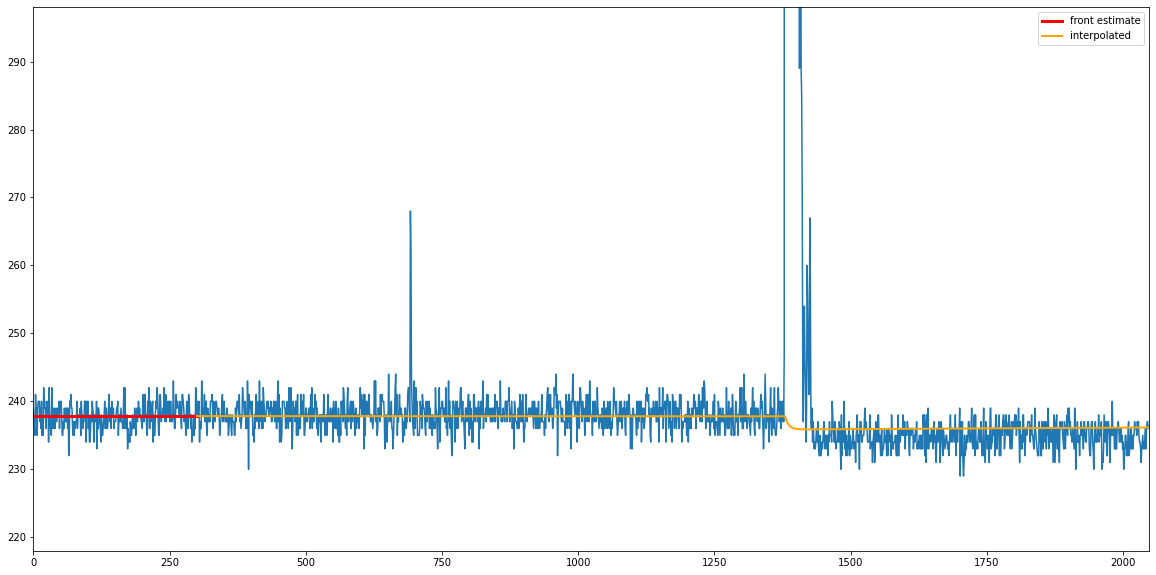

In [49]:
front, baseline = corrected_baseline(example_signal + FPGA_baseline)

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

plt.plot(range(len(example_signal) - 1), example_signal[1:] + FPGA_baseline)
plt.axhline(front, 0, 300/2048, c = "r", lw = 3, label = "front estimate")
plt.plot(range(300, 2048), baseline, label = "interpolated", c = "orange", lw = 2)
plt.xlim(0, 2048)
plt.ylim(-20 + FPGA_baseline, 60 + FPGA_baseline)
plt.legend()